In [1]:
from ioncast import *
from torch.utils.data import DataLoader
import datetime

In [2]:
# Create sequence dataset
# gim_dir = "/mnt/ionosphere-data/jpld/webdataset"
# omni_dir = "/mnt/ionosphere-data/omniweb/cleaned"
# celestrak_file = "/mnt/ionosphere-data/celestrak/kp_ap_processed_timeseries.csv"
# Create sequence dataset
gim_dir = "/mnt/disks/disk-main-data-1/data/jpld/webdataset"
omni_dir = "/mnt/disks/disk-main-data-1/data/omniweb/cleaned"
celestrak_file = "/mnt/disks/disk-main-data-1/data/celestrak/kp_ap_processed_timeseries.csv"

date_start = None
date_end = None

gim_dataset = JPLDGIMDataset(
    data_dir=gim_dir,
    date_start=date_start,
    date_end=date_end,
)

omni_dataset = OMNIDataset(
    file_dir=omni_dir,
    date_start=date_start,
    date_end=date_end,
)

celestrak_dataset = CelestrakDataset(
    file_name=celestrak_file,
    date_start=date_start,
    date_end=date_end,
)

sequence_dataset = Sequences([gim_dataset, omni_dataset, celestrak_dataset], delta_minutes=15, sequence_length=20)
# sequence_dataset = Sequences([gim_dataset], delta_minutes=15, sequence_length=20)


JPLD
Directory  : /mnt/disks/disk-main-data-1/data/jpld/webdataset
Loading tar files index from cache: /mnt/disks/disk-main-data-1/data/jpld/webdataset/tar_files_index


Start date : 2010-05-13 00:00:00
End date   : 2024-07-31 23:45:00
Delta      : 15 minutes
Loading dates from cache: /mnt/disks/disk-main-data-1/data/jpld/webdataset/dates_index_2010-05-13T00:00:00_2024-07-31T23:45:00
TEC maps total    : 498,623
TEC maps available: 498,481
TEC maps dropped  : 142

OMNIWeb dataset
File                 : /mnt/disks/disk-main-data-1/data/omniweb/cleaned/omni_5min_full_cleaned.csv
Rows                 : 2,103,840
Delta minutes        : 15
Normalize            : True
Rewind minutes       : 50
column:['B_mag', 'Bx_GSE', 'By_GSM', 'Bz_GSM', 'RMS_B_scalar', 'RMS_B_vector', 'V_flow', 'Vx', 'Vy', 'Vz', 'Density', 'Temp', 'SYM_D', 'SYM_H', 'ASY_D', 'ASY_H']
2103840


/home/hert7450/2025-HL-Ionosphere/ioncast/datasets/base_datasets.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Datetime'] = pd.to_datetime(self.data['Datetime']) # this line wasnt present previously but is necessary if the col contains strings instead of pandas timestamps for the date.to_pydatetime() to run as expected


Start date           : 2006-01-01 00:00:00
End date             : 2025-06-22 23:55:00
Rows after processing: 1,881,014

Celestrak dataset
File                 : /mnt/disks/disk-main-data-1/data/celestrak/kp_ap_processed_timeseries.csv
Rows                 : 198,320
Delta minutes        : 15
Normalize            : True
Rewind minutes       : 180
column:['Kp', 'Ap']
2379829
Start date           : 1957-10-01 00:00:00
End date             : 2025-08-14 21:00:00
Rows after processing: 2,379,829

Sequences
Start date              : 2010-05-13 00:00:00
End date                : 2024-07-31 23:45:00
Delta                   : 15 minutes
Sequence length         : 20
Sequence duration       : 300 minutes
Number of sequences     : 455,347
First sequence          : ['2010-05-13T07:30:00', '2010-05-13T07:45:00', '2010-05-13T08:00:00', '2010-05-13T08:15:00', '2010-05-13T08:30:00', '2010-05-13T08:45:00', '2010-05-13T09:00:00', '2010-05-13T09:15:00', '2010-05-13T09:30:00', '2010-05-13T09:45:00', '2010-05

In [ ]:
# Batch into 5 using a DataLoader
dataloader = DataLoader(
    sequence_dataset,
    batch_size=128,
    shuffle=True,
)

: 

In [ ]:
from ioncast import stack_features

# Iterate through the DataLoader
for batch in dataloader:
    # Print timestamp and features
    # print(f"Timestamps: {batch[-1]}")

    # timestamps = batch[-1]
    # jpld = batch[0]
    # omni = batch[1]
    # celestrak = batch[2]
    
    stacked_batch = stack_features(batch, model_type="IonCastConvLSTM")
    # print(stacked_batch)  # Print the stacked features
    # print(stacked_batch.shape)  # Print the shape of the stacked features
    print("JPLD 0, omni 1-16, celstrak 17-18, subsolar 19, sublunar 20, sin(tod) 21, cos(tod) 22, sin(doy) 23, cos(doy) 24")

    break

[process dataset features] took 3.1249 sec
[compute lat-lon grid] took 0.0009 sec
[compute subsolar & sublunar lat long points] took 0.0676 sec
[compute subsolar & sublunar haversine images] took 30.8566 sec
[compute timestamp encodings] took 0.4775 sec


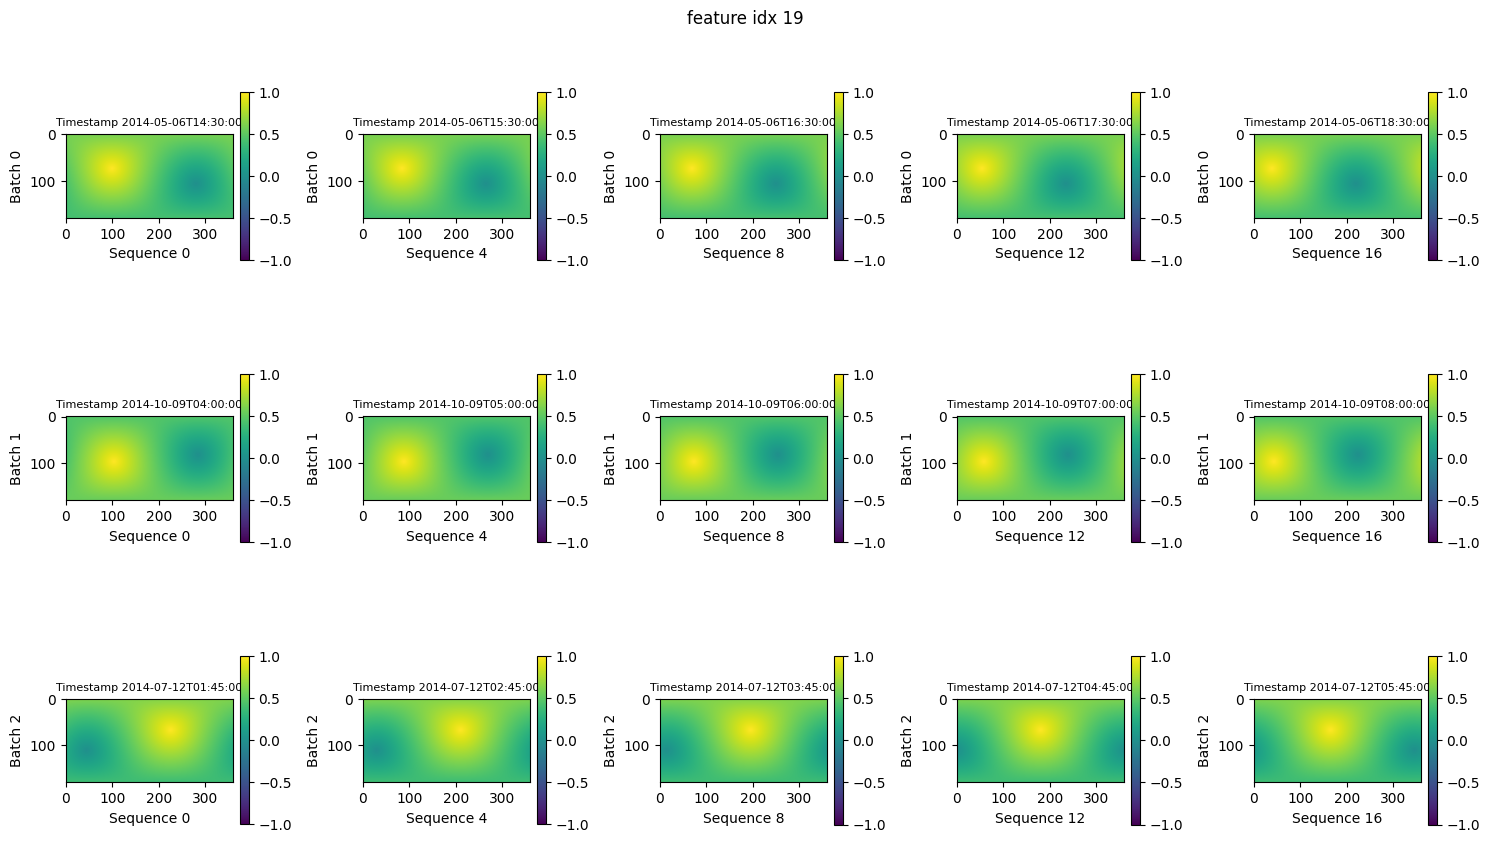

In [ ]:
# Create a 3 x 5 subplot plotting the first feature (vTEC) of the stacked_batch
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(3): # Batch
    # first_img = stacked_batch[i, 0, 0].cpu().numpy()  # First feature (vTEC)
    for j in range(5): # Sequence
        feature_idx = 19 # JPLD 0, omni 1-16, celstrak 17-18, subsolar 19, sublunar 20, sin(tod) 21, cos(tod) 22, sin(doy) 23, cos(doy) 24
        seq_idx = j*4

        axs[i, j].imshow(stacked_batch[i, seq_idx, feature_idx].cpu().numpy(), cmap='viridis', clim=(-1, 1))
        axs[i, j].set_title(f"Timestamp {timestamps[seq_idx][i]}", fontsize=8)
        axs[i, j].set_ylabel(f"Batch {i}")
        axs[i, j].set_xlabel(f"Sequence {seq_idx}")
        
        # add colorbar
        plt.colorbar(axs[i, j].images[0], ax=axs[i, j], orientation='vertical', fraction=0.046, pad=0.04)
        

plt.suptitle(f"feature idx {feature_idx}")
plt.tight_layout()
plt.show()

In [ ]:
np.cos(2*np.pi*(6*60 + 45)/(24*60))

np.float64(-0.19509032201612797)